In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

class NeuralNetwork:

    @staticmethod
    def sigma(x):
        return 1 / (np.exp(-x) + 1)

    @staticmethod
    def sigma_deriv(x):
        sig = NeuralNetwork.sigma(x)
        deriv = sig * (1 - sig)
        return deriv

    @staticmethod
    def softmax(x):
        # softmax function ---------
        t = np.exp(x - np.max(x))
        return t / np.sum(t, axis=1, keepdims=True)

    @staticmethod
    def get_activation_function(name):
        if name == 'sigma':
            return NeuralNetwork.sigma
        elif name == 'linear':
            return lambda x: x
        elif name == 'softmax':
            return NeuralNetwork.softmax
        elif name == 'tanh':
            return np.tanh
        elif name == 'relu':
            return lambda x: np.maximum(0, x)

    @staticmethod
    def get_activation_derivative(name):
        if name == 'sigma':
            return NeuralNetwork.sigma_deriv
        elif name == 'linear':
            return lambda x: np.ones_like(x)
        elif name == 'softmax':
            # jacobian of softmax - unused -------
            def softmax_deriv(x):
                value = NeuralNetwork.softmax(x)
                SM = value.reshape((-1, 1))
                jac = np.diagflat(value) - np.dot(SM, SM.T)
                return jac

            return softmax_deriv
        elif name == 'tanh':
            return lambda x: 1 - np.tanh(x)**2
        elif name == 'relu':
            return lambda x: x > 0


    @staticmethod
    def get_loss_function(name):
        if name == 'mse':
            return lambda x_pred, x: np.linalg.norm(x_pred - x)
        elif name == 'crossentropy':
            return lambda x_pred, x: -np.sum(x*np.log(x_pred))

    @staticmethod
    def get_loss_derivative(name):
        # currently unused
        if name == 'mse':
            return lambda x_pred, x: (x_pred - x)
        elif name == 'crossentropy':
            return lambda x_pred, x: x*(-1/x_pred)

    class Layer:
        def __init__(self, input_width, layer_width, activation_function):
            # self.weights = np.random.uniform(0, 1, (input_width + 1, layer_width))
            self.weights = np.random.normal(0, 1, (input_width + 1, layer_width))
            self.activation_function = activation_function

        def predict(self, x):
            activation_function = NeuralNetwork.get_activation_function(self.activation_function)
            return activation_function(np.dot(x, self.weights))

        def feedforward_step(self, x):
            activation_function = NeuralNetwork.get_activation_function(self.activation_function)
            activation = np.dot(x, self.weights)
            response = activation_function(activation)
            return response, activation

    def __init__(self, input_width, output_width, activation_function='sigma', loss_function='mse', bias_exists=True, seed=None, verbose=True):
        ###
        # create a new nn object. activation_function specifies activation used on hidden layers
        # loss_function affects loss printed to console
        ###
        self.input_width = input_width
        self.output_width = output_width
        self.layers = []
        self.activation_function = activation_function
        self.loss_function = NeuralNetwork.get_loss_function(loss_function)
        self.loss_derivative = NeuralNetwork.get_loss_derivative(loss_function)
        self.bias_exists = bias_exists
        self.seed = seed
        sefl.verbose = verbose

    def add_layer(self, layer_width):
        ###
        # add a hidden layer with specified number of neurons
        ###
        if len(self.layers) == 0:
            self.layers.append(NeuralNetwork.Layer(self.input_width, layer_width, self.activation_function))
        else:
            self.layers.append(
                NeuralNetwork.Layer(self.layers[-1].weights.shape[1], layer_width, self.activation_function))


    def predict(self, x):
        ###
        # predict responses on new data
        ###
        values = np.copy(x)
        for layer in self.layers:
            values = np.hstack((values, np.ones((values.shape[0], 1)) if self.bias_exists else np.zeros((values.shape[0], 1))))
            values = layer.predict(values)
        return values

    def create_output_layer(self, activation_function='linear'):
        ###
        # create output layer with specified activation function. Use after adding all hidden layers and before training
        ###
        if len(self.layers) == 0:
            self.layers.append(NeuralNetwork.Layer(self.input_width, self.output_width, activation_function))
        else:
            self.layers.append(
                NeuralNetwork.Layer(self.layers[-1].weights.shape[1], self.output_width, activation_function))

    def feedforward(self, x):
        response = np.copy(x)
        response = response.reshape(1, -1)
        response = np.hstack((response, np.ones((response.shape[0], 1))))
        response_s = [response]
        activation_s = []
        for i in range(len(self.layers) - 1):
            response, activation = self.layers[i].feedforward_step(response_s[i])
            activation_s.append(activation)
            response = response.reshape(1, -1)
            response = np.hstack((response, np.ones((response.shape[0], 1))))
            response_s.append(response)
        response, activation = self.layers[-1].feedforward_step(response_s[-1])
        activation_s.append(activation)
        response = response.reshape(1, -1)
        response_s.append(response)
        return (response_s, activation_s)

    def backpropagation(self, x, y, r_s, a_s):
        e_s = [None] * len(self.layers)

        ###
        # derivative of loss function in respect to final layer weights
        # assuming loss is crossentropy and output layer is softmax
        # formula is the same as in the case of linear outputs and mse
        ###
        e_s[-1] = a_s[-1] - y

        for i in reversed(range(1, len(e_s))):
            unbiased_weights = self.layers[i].weights[0:(self.layers[i].weights.shape[0] - 1), :]
            e_s[i-1] = NeuralNetwork.get_activation_derivative(self.layers[i-1].activation_function)(a_s[i-1])*(e_s[i].dot(unbiased_weights.T))
        gradient = [r_s[j].T.dot(e_s[j]) for j in range(0, len(self.layers))]
        return gradient

    def train(self, x, y, batch_size=10, epochs=100, lr=0.01, method='basic', method_param=0.0):
        ###
        # train network. method can be 'basic', 'momentum' or 'rmsprop'.
        # method_param specifies lambda in momentum or beta in rmsprop
        ###
        if self.seed is not None:
            np.random.seed(self.seed)
        errors = []
        eps = 1e-8
        momentum = [np.zeros(layer.weights.shape) for layer in self.layers]
        for e in range(epochs):
            permutation = np.random.permutation(y.shape[0])
            x = x[permutation, :]
            y = y[permutation, :]
            i = 0
            while i < y.shape[0]:
                deltas = [np.zeros(layer.weights.shape) for layer in self.layers]
                x_batch = x[i:i + batch_size, :]
                y_batch = y[i:i + batch_size, :]
                i = i + batch_size
                for j in range(0, y_batch.shape[0]):
                    r_s, a_s = self.feedforward(x_batch[j, :])
                    gradient = self.backpropagation(x_batch[j, :], y_batch[j, :], r_s, a_s)
                    for k in range(0, len(deltas)):
                        deltas[k] = deltas[k] - gradient[k]

                if method == 'momentum':
                    momentum = [delta + method_param * mom for mom, delta in zip(momentum, deltas)]
                elif method == 'rmsprop':
                    momentum = [method_param * mom + (1 - method_param)*np.square(delta) for mom, delta in zip(momentum, deltas)]

                for j in range(0, len(deltas)):
                    if method == 'momentum':
                        self.layers[j].weights = self.layers[j].weights + lr*momentum[j]
                    elif method == 'rmsprop':
                        self.layers[j].weights = self.layers[j].weights + lr * (deltas[j] / (np.sqrt(momentum[j]) + eps))
                    else:
                        self.layers[j].weights = self.layers[j].weights + lr*deltas[j]

                error = self.loss_function(self.predict(x_batch), y_batch)
                if self.verbose:
                    print("loss on batch = {}".format(error))
                errors.append(error)
        return errors


# TESTS ------------------------------------------------------------------------
# set path to dataset folders
classification = "projekt1/classification/"
regression = "projekt1/regression/"

# side functions

def nnerrors(inputw, outputw, activation, X, y, layers1, layers2, layers3, output_activation='linear', loss='mse', epochs=4):
    nn1 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers1:
        nn1.add_layer(layer)
    nn1.create_output_layer(output_activation)
    nn2 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers2:
        nn2.add_layer(layer)
    nn2.create_output_layer(output_activation)
    nn3 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers3:
        nn3.add_layer(layer)
    nn3.create_output_layer(output_activation)

    errors1 = nn1.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)
    errors2 = nn2.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)
    errors3 = nn3.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)

    return [errors1, errors2, errors3]


def make_plots(inputw, outputw, X, y, layers1, layers2, layers3, output_activation, loss, label1, label2, label3, suptitle, ylim=(0, 20), epochs=4):
    np.random.seed(42)
    sigma_error = nnerrors(inputw, outputw, 'sigma', X, y, layers1, layers2, layers3, output_activation, loss, epochs)
    tanh_error = nnerrors(inputw, outputw, 'tanh', X, y, layers1, layers2, layers3, output_activation, loss, epochs)
    relu_error = nnerrors(inputw, outputw, 'relu', X, y, layers1, layers2, layers3, output_activation, loss, epochs)

    x_err = range(len(sigma_error[0]))

    fig, axis = plt.subplots(1, 3, figsize=(10,5))
    plt.setp(axis, ylim=ylim)
    axis[0].plot(x_err, sigma_error[0], label=label1)
    axis[0].plot(x_err, sigma_error[1], label=label2)
    axis[0].plot(x_err, sigma_error[2], label=label3)
    axis[0].set_title('sigma')
    axis[0].set_ylabel(loss)
    axis[1].plot(x_err, tanh_error[0])
    axis[1].plot(x_err, tanh_error[1])
    axis[1].plot(x_err, tanh_error[2])
    axis[1].set_title('tanh')
    axis[2].plot(x_err, relu_error[0])
    axis[2].plot(x_err, relu_error[1])
    axis[2].plot(x_err, relu_error[2])
    axis[2].set_title('relu')
    fig.legend()
    fig.suptitle(suptitle)
    fig.show()

In [3]:
f = open(classification + "data.three_gauss.train.1000.csv")
gauss3train = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0, 1, 2))
f.close()
X_train = gauss3train[:, 0:2]
y_train = gauss3train[:, 2]
y_train = y_train.reshape(-1, 1)
encoder_gauss3 = OneHotEncoder(sparse=False)
y_gauss3train = encoder_gauss3.fit_transform(y_train)
X_gauss3train = X_train

f = open(classification + "data.three_gauss.test.1000.csv")
gauss3test = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0, 1, 2))
f.close()
X_test = gauss3test[:, 0:2]
y_test = gauss3test[:, 2]
y_test = y_test.reshape(-1, 1)
y_gauss3test = encoder_gauss3.transform(y_test)
X_gauss3test = X_test


loss on batch = 1315.9256161811454
loss on batch = 1184.3599066620118
loss on batch = 982.2583406484796
loss on batch = 887.9095855435913
loss on batch = 810.6580563415098
loss on batch = 718.2246748193818
loss on batch = 668.3472178022566
loss on batch = 622.5202171394513
loss on batch = 586.8742113690541
loss on batch = 559.4438134684247
loss on batch = 543.9240735063977
loss on batch = 541.7885593843018
loss on batch = 538.2429092535139
loss on batch = 539.7053344944242
loss on batch = 538.1553498077835
loss on batch = 537.3852713902163
loss on batch = 536.5332967239749
loss on batch = 529.3311549646568
loss on batch = 532.436304480181
loss on batch = 527.7532297217925
loss on batch = 523.0084449659341
loss on batch = 517.2045306787447
loss on batch = 516.9335646953903
loss on batch = 513.1401572250104
loss on batch = 513.6560107679752
loss on batch = 504.25252928247073
loss on batch = 502.6642354578779
loss on batch = 498.960805522825
loss on batch = 494.3167410022992
loss on batch

/home/pysiakk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


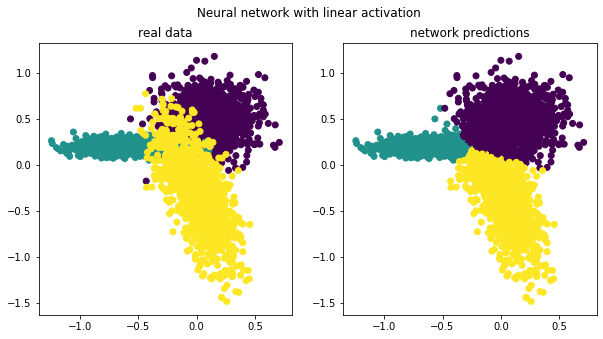

In [5]:
nn = NeuralNetwork(2, 3, loss_function='crossentropy')

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer('softmax')
nn.errors = nn.train(X_gauss3train, y_gauss3train, epochs=20, batch_size=500, lr=.05, method='rmsprop', method_param=0.2)
pred = nn.predict(X_gauss3test)

# Plot example
y = encoder_gauss3.inverse_transform(y_gauss3test)
y_pred = encoder_gauss3.inverse_transform(pred)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

axis[0].scatter(X_gauss3test[:,0].flatten(), X_gauss3test[:,1].flatten(), c = y.flatten())
axis[0].set_title('real data')
axis[1].scatter(X_gauss3test[:,0].flatten(), X_gauss3test[:,1].flatten(), c = y_pred.flatten())
axis[1].set_title('network predictions')
fig.suptitle('Neural network with linear activation')
fig.show()

In [52]:
f = open(regression + 'data.activation.train.10000.csv')
X, y = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0,1), unpack=True)
f.close()

X = (X-np.mean(X))/np.std(X)
y = (y-np.mean(y))/np.std(y)
X_activation_train = X.reshape(-1,1)
y_activation_train = y.reshape(-1,1)


f = open(regression + 'data.activation.test.10000.csv')
X, y = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0,1), unpack=True)
f.close()

X = (X-np.mean(X))/np.std(X)
y = (y-np.mean(y))/np.std(y)
X_activation_test = X.reshape(-1,1)
y_activation_test = y.reshape(-1,1)


In [61]:
nn = NeuralNetwork(1, 1)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer()
nn.errors = nn.train(X_activation_train, y_activation_train, epochs=5, batch_size=100, lr=.05, method='rmsprop', method_param=0.2)
pred = nn.predict(X_activation_test)

# Plot example


plt.scatter(X_activation_test.flatten(), y_activation_test.flatten(), label='real data')
plt.scatter(X_activation_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()


NameError: name 'X_activation_train' is not defined

In [47]:
data = pd.read_csv("projekt1/regression/data.activation.train.10000.csv")
X_train = np.array(data.iloc[:,:1])
y_train = np.array(data.iloc[:,1:])
data = pd.read_csv("projekt1/regression/data.activation.test.10000.csv")
X_test = np.array(data.iloc[:,:1])
y_test = np.array(data.iloc[:,1:])
X_test = (X_test - np.mean(X_train)) / np.std(X_train)
y_test = (y_test - np.mean(y_train)) / np.std(y_train)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
y_train = (y_train - np.mean(y_train)) / np.std(y_train)
print(X_train)
print(y_train)

[[-0.61804391]
 [ 0.63565033]
 [ 1.10413489]
 ...
 [-0.60777057]
 [-1.19618858]
 [-0.18647261]]
[[-0.45938957]
 [ 0.83263424]
 [ 0.95225293]
 ...
 [-0.44217055]
 [-1.40181267]
 [ 0.19361084]]


loss on batch = 9.058152687387773
loss on batch = 9.20349510356649
loss on batch = 10.400545417321247
loss on batch = 10.362328806792457
loss on batch = 9.337011450871774
loss on batch = 10.352903375300878
loss on batch = 9.873852101587504
loss on batch = 9.303638264813712
loss on batch = 9.73226887030746
loss on batch = 9.274846040209557
loss on batch = 9.067670081780753
loss on batch = 10.238121784734945
loss on batch = 10.051204051644293
loss on batch = 10.930540503716308
loss on batch = 10.1755949944492
loss on batch = 10.191907006864863
loss on batch = 9.157723258925763
loss on batch = 10.0371745401937
loss on batch = 10.005811669154374
loss on batch = 10.480247076334374
loss on batch = 9.884847197017828
loss on batch = 8.630858093412956
loss on batch = 9.611070248828511
loss on batch = 8.08268664234676
loss on batch = 9.45072269659974
loss on batch = 10.02802580066277
loss on batch = 9.487955817619659
loss on batch = 9.451308055306042
loss on batch = 10.330801965479486
loss on ba

loss on batch = 0.6552871642918823
loss on batch = 0.7263364785907533
loss on batch = 0.6772138814773175
loss on batch = 0.7083923549738508
loss on batch = 0.6944164252911481
loss on batch = 0.6068025983425229
loss on batch = 0.6499121047721115
loss on batch = 0.663459551421608
loss on batch = 0.658472142542361
loss on batch = 0.6220756093020751
loss on batch = 0.6746907820271022
loss on batch = 0.6706941469445494
loss on batch = 0.675128679617041
loss on batch = 0.6264996007396422
loss on batch = 0.6115170760144897
loss on batch = 0.6907367814952543
loss on batch = 0.5915347436349133
loss on batch = 0.6231446905963581
loss on batch = 0.6578776927383508
loss on batch = 0.6439783010608771
loss on batch = 0.6271071513705138
loss on batch = 0.6301250949711602
loss on batch = 0.6992200573992244
loss on batch = 0.5938054304330909
loss on batch = 0.6166523761600063
loss on batch = 0.6543980825665923
loss on batch = 0.659839961114177
loss on batch = 0.6513580208484998
loss on batch = 0.709370

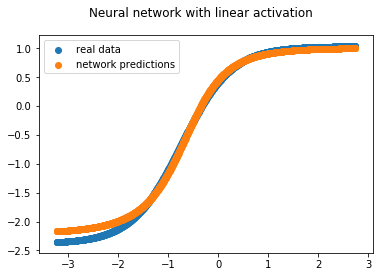

MSE: 0.007979045500215633


In [76]:
nn = NeuralNetwork(1, 1, activation_function="sigma", seed=123, verbose=False)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=100, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()


print("MSE: " + str(np.mean((pred - y_test)**2)))

loss on batch = 8.923050420259909
loss on batch = 8.984946664815965
loss on batch = 10.133497123301085
loss on batch = 9.86339659763863
loss on batch = 8.276047308243538
loss on batch = 9.264572516846949
loss on batch = 7.978591635329542
loss on batch = 6.712110261489054
loss on batch = 6.710436507405033
loss on batch = 5.542789521833328
loss on batch = 5.277737802174194
loss on batch = 7.429964762461732
loss on batch = 10.39189920974374
loss on batch = 13.981469321714046
loss on batch = 7.467345927099526
loss on batch = 6.3490812838123585
loss on batch = 4.891370224411563
loss on batch = 5.442104812023931
loss on batch = 6.775739425597381
loss on batch = 8.772234232898407
loss on batch = 12.938996660703273
loss on batch = 4.888063747140598
loss on batch = 5.375413587630316
loss on batch = 3.8592464070943566
loss on batch = 4.973246550626708
loss on batch = 5.04677914679711
loss on batch = 4.765878665270568
loss on batch = 6.545704041048629
loss on batch = 11.336943148213022
loss on ba

loss on batch = 9.544167242821109
loss on batch = 8.89061761577616
loss on batch = 8.69191733362246
loss on batch = 7.704161455247347
loss on batch = 7.194089944579704
loss on batch = 6.671059530891178
loss on batch = 5.554795697342004
loss on batch = 5.354420318493872
loss on batch = 4.519152161095838
loss on batch = 5.036629642647675
loss on batch = 4.848416056422299
loss on batch = 5.341680807803904
loss on batch = 6.518036781101543
loss on batch = 10.120349873533248
loss on batch = 5.818991628869994
loss on batch = 7.977473637369521
loss on batch = 7.7723578227486705
loss on batch = 14.56646582618017
loss on batch = 7.757294359585259
loss on batch = 5.476979700539949
loss on batch = 5.951716134592784
loss on batch = 5.6658632377928875
loss on batch = 5.776538806817979
loss on batch = 4.210714985218171
loss on batch = 4.422380188729828
loss on batch = 5.021359232941296
loss on batch = 6.140918585495847
loss on batch = 7.555420456227998
loss on batch = 12.92153276178758
loss on batch

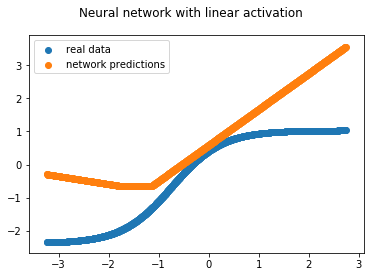

In [73]:
nn = NeuralNetwork(1, 1, activation_function="relu", seed=123)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=100, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()

loss on batch = 9.53700629225264
loss on batch = 9.297477991086392
loss on batch = 9.979767544695797
loss on batch = 9.212147335158159
loss on batch = 7.624957571292464
loss on batch = 7.251098405711155
loss on batch = 5.576715443651366
loss on batch = 4.113394702993462
loss on batch = 3.5108445309185035
loss on batch = 2.698949515386965
loss on batch = 2.3709096360429047
loss on batch = 2.4019529549960406
loss on batch = 2.078806255581563
loss on batch = 2.444880031099774
loss on batch = 1.947635430387282
loss on batch = 2.042595388506207
loss on batch = 1.811457551558705
loss on batch = 1.9861431793268782
loss on batch = 1.8763776992071766
loss on batch = 1.8564308587302631
loss on batch = 1.8940969848367153
loss on batch = 1.7093177225471452
loss on batch = 1.8436357318658727
loss on batch = 1.7066187495016063
loss on batch = 1.8280678538863286
loss on batch = 1.7599810141886267
loss on batch = 1.7078310690203315
loss on batch = 1.7417485078365094
loss on batch = 1.666217118387756
l

loss on batch = 2.2168267804055404
loss on batch = 2.9042416108489553
loss on batch = 2.1457636320071276
loss on batch = 1.616583892487658
loss on batch = 1.3355055114350523
loss on batch = 1.2202394757460842
loss on batch = 1.240870182104931
loss on batch = 1.214689786215032
loss on batch = 1.0743903665303385
loss on batch = 1.0731826124116486
loss on batch = 1.2144982604673948
loss on batch = 1.2156095286142614
loss on batch = 1.215534529489997
loss on batch = 1.001116385859113
loss on batch = 1.1365954615087954
loss on batch = 1.168646132017576
loss on batch = 1.2833850541597158
loss on batch = 1.0891066311289748
loss on batch = 0.9990442571744114
loss on batch = 1.0596532890208905
loss on batch = 1.0217129473654554
loss on batch = 1.1311765346621054
loss on batch = 0.8482399100976393
loss on batch = 0.9967106221953604
loss on batch = 1.0930889503889685
loss on batch = 1.4290444191723617
loss on batch = 2.104539975158281
loss on batch = 2.0951245670679657
loss on batch = 2.472503440

loss on batch = 3.5227227931734113
loss on batch = 1.9745118271913726
loss on batch = 1.7596528067919344
loss on batch = 2.881589770934977
loss on batch = 2.57319395022577
loss on batch = 1.869801942276834
loss on batch = 1.612359614658073
loss on batch = 1.146756739459816
loss on batch = 1.142096723583652
loss on batch = 1.1371113667411998
loss on batch = 0.8834691034854244
loss on batch = 0.7716253948657794
loss on batch = 0.8489397141766208
loss on batch = 0.7075189467603369
loss on batch = 0.9789702205813334
loss on batch = 0.8219050688232896
loss on batch = 0.7975690583862335
loss on batch = 0.8452129323381825
loss on batch = 0.7546997228868072


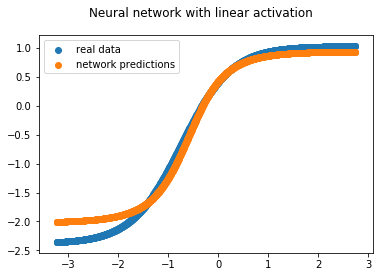

In [74]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=123)

# Multiple layers
nn.add_layer(2)
nn.add_layer(2)

nn.create_output_layer()
nn.errors = nn.train(X_train, y_train, epochs=5, batch_size=100, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(X_test)

# Plot example


plt.scatter(X_test.flatten(), y_test.flatten(), label='real data')
plt.scatter(X_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()